In [ ]:
import numpy as np
import pandas as pd
import polars as pl
import os
import random as rnd
os.chdir('..')
os.chdir('src')
from env import BlackjackEnv


In [15]:
def parse_csv_file(file_path):
    """
    Parse a CSV file and return a DataFrame.
    
    Parameters:
    file_path (str): Path to the CSV file
    
    Returns:
    pd.DataFrame: Parsed DataFrame
    """
    try:
        df = pl.read_csv(file_path)
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# avg_Q = parse_csv_file('double_q_strat.csv')
# basic_strat = parse_csv_file('basic_strat.csv')

In [16]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1],
    "actions": ["stand", "hit"],
    "num_players": 1
}
# Create environment with 6 decks (standard casino configuration)
env = BlackjackEnv(config=config)


### Initialization of Q table

In [17]:
# Generate relevant states - focusing on decision points that matter
states = []
# For hard totals (no usable ace), only track 12-21
# Below 12, the optimal play is always hit
for player_sum in range(5, 22):
    for dealer_card in range(2, 12):
        states.append((player_sum, dealer_card, 0))  # Hard total

# For soft totals (with usable ace), track 12-21
# Soft totals below 12 are impossible (A+1 = 12)
for player_sum in range(12, 22):
    for dealer_card in range(2, 12):
        states.append((player_sum, dealer_card, 1))  # Soft total

In [18]:

# Initialize Q-table with strategic initial values
q_data = {
    'State': states,
    'Action 0 (Stand)': np.zeros(len(states)),
    'Action 1 (Hit)': np.zeros(len(states))
}

# Strategic initialization: Set high values for "stand" in 20-21, high values for "hit" in 4-11
for i, state in enumerate(states):
    player_sum, _, _ = state
    if player_sum >= 20:
        # For high player sums, initialize stand value higher
        q_data['Action 0 (Stand)'][i] = 0.5
        q_data['Action 1 (Hit)'][i] = -0.1
    elif player_sum < 12:
        # For low player sums, initialize hit value higher
        q_data['Action 0 (Stand)'][i] = -0.1
        q_data['Action 1 (Hit)'][i] = 0.5

Q = pl.DataFrame(q_data)

# Double Q-learning: Second Q-table for reducing bias
Q2 = Q.clone()

In [19]:
# Track state-action visit counts for adaptive learning rates
visit_counts = {}
for state in states:
    visit_counts[(state, 0)] = 0  # Stand
    visit_counts[(state, 1)] = 0  # Hit

### Hyperparameters

In [20]:
# Improved hyperparameters
initial_lr = 0.1             # Learning rate
lr_decay_rate = 0.00005      # Gentler decay rate
gamma = 0.95                 # Higher discount factor - long-term rewards matter mor
initial_epsilon = 1.0        # Start with 100% exploration
epsilon_min = 0.01           # Minimum exploration rate
epsilon_decay = 0.99995      # Much slower decay rate

### Helper functions Strategy Q-table

In [21]:

# Modified state representation - focusing on meaningful game states
def get_state_features(full_state):
    # Extract just player sum, dealer card, and usable ace
    player_sum = full_state[0]
    dealer_card = full_state[1]
    usable_ace = full_state[2]
    return (player_sum, dealer_card, usable_ace)


In [22]:
def get_adaptive_lr(state, action, base_lr):
    """Get state-action specific learning rate based on visit count"""
    key = (state, action)
    count = visit_counts.get(key, 0) + 1
    # Decay learning rate based on visit count, but maintain a minimum rate
    return max(base_lr / (1 + 0.005 * count), base_lr * 0.1)

In [23]:
def get_q_values(state_features, q_table=Q):
    """Get Q-values for a given state"""

    # Filter the DataFrame for the specific state
    state_row = q_table.filter(pl.col('State') == state_features)
    if len(state_row) == 0:
        # Return default values based on player sum
        player_sum = state_features[0]
        if player_sum < 12:
            return np.array([-0.1, 0.5])  # Default to hit for low sums
        elif player_sum >= 20:
            return np.array([0.5, -0.1])  # Default to stand for high sums
        else:
            return np.array([0.0, 0.0])  # Neutral for middle sums
    
            
    # Extract Q-values from the DataFrame
    stand_val = state_row.select('Action 0 (Stand)').item()
    hit_val = state_row.select('Action 1 (Hit)').item()
    return np.array([stand_val, hit_val])


In [24]:
def update_q_value(state_features, action, reward, next_state_features, lr, q_table=Q, q_table_target=Q2):
    """Update Q-value for state-action pair using Double Q-learning"""
    # Check if state exists in our table
    state_row = q_table.filter(pl.col('State') == state_features)
    if len(state_row) == 0:
        return # State not in our table
    
    # Determine which action column to update
    action_col = 'Action 1 (Hit)' if action == 1 else 'Action 0 (Stand)'
    
    # Current Q-value in the DataFrame
    current_q = state_row.select(action_col).item()
    
    # If next_state_features is None, this is a terminal state
    if next_state_features is None:
        # Terminal state - no future rewards
        new_q = current_q + lr * (reward - current_q)
    else:
        # Get the next state's best action from current Q-table
        next_q_values = get_q_values(next_state_features, q_table)
        best_next_action = np.argmax(next_q_values)
        
        # Get Q-value for best action from target Q-table
        next_q_values_target = get_q_values(next_state_features, q_table_target)
        max_next_q = next_q_values_target[best_next_action]
        
        # Q-learning update formula with future rewards
        new_q = current_q + lr * (reward + gamma * max_next_q - current_q)
    
    # Update the Q-table entry in the DataFrame
    # Create a temporary mask for the state we want to update
    mask = pl.col('State') == state_features
    
    # Use the when/then/otherwise pattern to update values
    q_table = q_table.with_columns(
        pl.when(mask)
        .then(pl.lit(new_q))
        .otherwise(pl.col(action_col))
        .alias(action_col)
    )
    
    # Track visit counts
    visit_counts[(state_features, action)] = visit_counts.get((state_features, action), 0) + 1
    
    return q_table

### Training Q-table

In [25]:
# Training loop with convergence check
print("Starting improved training...")
wins = 0
draws = 0
losses = 0
epsilon = initial_epsilon
lr = initial_lr
money_won = 0
money_lost = 0

# Parameters for convergence
n_episodes = 500000  # Number of episodes for training
convergence_threshold = 0.001  # Lower threshold for better stability
convergence_check_interval = 10000  # Check for convergence every N episodes
convergence_required_count = 3  # Number of consecutive checks below threshold to confirm convergence
max_episodes = n_episodes  # Maximum episodes as a fallback

# Keep a copy of the previous Q-table for comparison
previous_q = Q.clone()
convergence_count = 0
converged = False
episode = 0
#first training phase only for the Q-table with fixed betting strategy
while episode < max_episodes and not converged:

    env.reset()
    bet_index = env.bet_space.sample()  # Sample bet index from the environment
    bet_amount = env.bets[bet_index]  # Sample bet amount from the environment
    # print(env.step(bet_index, action_type="bet"))
    state, reward, done = env.step(bet_index, action_type="bet")  # Place bet
    if done:
        if reward > 0:
            wins += 1
            money_won += reward * bet_amount
        elif reward == 0:
            draws += 1
        else:
            losses += 1
            money_lost += abs(reward) * bet_amount
    # print(bet_amount)
    state_features = get_state_features(state)

    # Training episode
    while not done:
        
        if state_features[0] < 12:
        # Always hit this state as it's not relevant for our training
            next_state, _, _ = env.step(1, action_type="move")
            next_state_features = get_state_features(next_state) if not done else None
            state = next_state
            state_features = next_state_features if next_state is not None else None
            continue
        
        # Epsilon-greedy action selection
        elif np.random.rand() < epsilon:
            action = env.move_space.sample()  # Random action
        else:
            q_values = get_q_values(state_features)
            action = np.argmax(q_values)  # Greedy action
        
        # Take action
        next_state, reward, done = env.step(action, action_type="move")
        next_state_features = get_state_features(next_state) if not done else None

        # Get adaptive learning rate for this state-action pair
        adaptive_lr = get_adaptive_lr(state_features, action, lr)

        # Randomly decide which Q-table to update (Double Q-learning)
        # print(f"State: {state_features}, Action: {action}, Done: {done}, Reward: {reward}, Next State: {next_state_features}")
        if np.random.rand() < 0.5:
            # print("Updating Q-table 1")
            Q = update_q_value(state_features, action, reward*bet_amount, next_state_features, adaptive_lr, Q, Q2)
        else:
            # print("Updating Q-table 2")
            Q2 = update_q_value(state_features, action, reward*bet_amount, next_state_features, adaptive_lr, Q2, Q)
            
        # Track outcomes
        if done:
            if reward > 0:
                wins += 1
                money_won += reward * bet_amount
            elif reward == 0:
                draws += 1
            else:
                losses += 1
                money_lost += abs(reward) * bet_amount
        
        state = next_state
        state_features = next_state_features if next_state is not None else None
        
        if state_features is None:
            # print(f"Entered break condition with done being {done}")
            break
    
    # Decay epsilon and learning rate
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    lr = initial_lr / (1 + lr_decay_rate * episode)
    
    # Check for convergence periodically
    if episode % convergence_check_interval == 0 and episode > 0:
        # Calculate the maximum absolute difference between current and previous Q-values
        diff_stand = (Q.select('Action 0 (Stand)').to_numpy() - 
                     previous_q.select('Action 0 (Stand)').to_numpy())
        diff_hit = (Q.select('Action 1 (Hit)').to_numpy() - 
                   previous_q.select('Action 1 (Hit)').to_numpy())
        
        max_diff_stand = np.max(np.abs(diff_stand))
        max_diff_hit = np.max(np.abs(diff_hit))
        max_diff = max(max_diff_stand, max_diff_hit)
        
        if max_diff < convergence_threshold:
            convergence_count += 1
            print(f"Episode {episode}, max Q-value change: {max_diff:.6f} (convergence count: {convergence_count}/{convergence_required_count})")
            if convergence_count >= convergence_required_count:
                print(f"Converged after {episode} episodes (max Q-value change: {max_diff:.6f})")
                converged = True
        else:
            convergence_count = 0
            print(f"Episode {episode}, max Q-value change: {max_diff:.6f}")
        
        # Store current Q-values for next comparison
        previous_q = Q.clone()
    
    episode += 1

# Final statistics
total_episodes = episode
print(f"Training complete after {total_episodes} episodes.")
print(f"Win rate: {wins/total_episodes:.4f}")
print(f"Draw rate: {draws/total_episodes:.4f}")
print(f"Loss rate: {losses/total_episodes:.4f}")

Starting improved training...
Episode 10000, max Q-value change: 0.869015
Episode 20000, max Q-value change: 0.432170
Episode 30000, max Q-value change: 0.338331
Episode 40000, max Q-value change: 0.192235
Episode 50000, max Q-value change: 0.180681
Episode 60000, max Q-value change: 0.147989
Episode 70000, max Q-value change: 0.163957
Episode 80000, max Q-value change: 0.080114
Episode 90000, max Q-value change: 0.082432
Episode 100000, max Q-value change: 0.057556
Episode 110000, max Q-value change: 0.069535
Episode 120000, max Q-value change: 0.055000
Episode 130000, max Q-value change: 0.048622
Episode 140000, max Q-value change: 0.048125
Episode 150000, max Q-value change: 0.033981
Episode 160000, max Q-value change: 0.041305
Episode 170000, max Q-value change: 0.029073
Episode 180000, max Q-value change: 0.037460
Episode 190000, max Q-value change: 0.030373
Episode 200000, max Q-value change: 0.036301
Episode 210000, max Q-value change: 0.027813
Episode 220000, max Q-value change

### Testing Q-table win rate

In [26]:

# Evaluate the final policy with more episodes
print("\nFinal policy evaluation...")
eval_wins = 0
eval_draws = 0
eval_loss = 0
money_won = 0
money_lost = 0
eval_episodes = 10000

for _ in range(eval_episodes):
    env.reset()
    bet_index = env.bet_space.sample()  # Sample bet index from the environment
    bet_amount = env.bets[bet_index]  # Sample bet amount from the environment
    # print(env.step(bet_index, action_type="bet"))
    state, reward, done = env.step(bet_index, action_type="bet")  # Place bet
    if done:
        if reward > 0:
            eval_wins += 1
            money_won += reward * bet_amount
        elif reward == 0:
            eval_draws += 1
        else:
            eval_loss += 1
            money_lost += abs(reward) * bet_amount
    # print(bet_amount)
    state_features = get_state_features(state)

    # Training episode
    while not done:
        # Always choose the best action according to average of both Q-tables
        q_values1 = get_q_values(state_features, Q)
        q_values2 = get_q_values(state_features, Q2)
        avg_q_values = (q_values1 + q_values2) / 2
        action = np.argmax(avg_q_values)
        
        next_state, reward, done = env.step(action, action_type="move")
        
        if done and reward > 0:
            eval_wins += 1
            money_won += reward * bet_amount
        elif done and reward == 0:
            eval_draws += 1
        elif done and reward < 0:
            eval_loss += 1
            money_lost += abs(reward) * bet_amount
        else:
            pass
        
        state = next_state
        state_features = get_state_features(state)

        if done:
            break

print(f"Final evaluation complete.")
print(f"Win rate: {eval_wins/eval_episodes:.4f}")
print(f"Draw rate: {eval_draws/eval_episodes:.4f}")
print(f"Loss rate: {eval_loss/eval_episodes:.4f}")
print(f"Money won: {money_won}")
print(f"Money lost: {money_lost}")


Final policy evaluation...
Final evaluation complete.
Win rate: 0.4252
Draw rate: 0.0909
Loss rate: 0.4839
Money won: 4481.5
Money lost: 4839


### Benchmarking with basic strategy

In [27]:
basic_strat = parse_csv_file('basic_strat.csv')
# Change the type of the column 'State' from string of the form '[12 3 0]' to List(Int64)
basic_strat = basic_strat.with_columns(
    pl.col("State").map_elements(
        lambda x: [int(i) for i in x[1:-1].split()],  # Parse the string into a list of integers
        return_dtype=pl.List(pl.Int64)  # Specify the return data type
    ).alias("State")
)


In [28]:
# Evaluate the final policy with more episodes
print("\nFinal policy evaluation...")
bench_wins = 0
bench_draws = 0
bench_loss = 0
money_won = 0
money_lost = 0
bench_episodes = 10000

for _ in range(bench_episodes):
    env.reset()
    bet_index = env.bet_space.sample()  # Sample bet index from the environment
    bet_amount = env.bets[bet_index]  # Sample bet amount from the environment
    # print(env.step(bet_index, action_type="bet"))
    state, reward, done = env.step(bet_index, action_type="bet")  # Place bet
    if done:
        if reward > 0:
            bench_wins += 1
            money_won += reward * bet_amount
        elif reward == 0:
            bench_draws += 1
        else:
            bench_loss += 1
            money_lost += abs(reward) * bet_amount
    # print(bet_amount)
    state_features = get_state_features(state)

    # Training episode
    while not done:
        # Always choose the best action according to average of both Q-tables
        q_values = get_q_values(state_features, basic_strat)
        action = np.argmax(q_values)
        
        next_state, reward, done = env.step(action, action_type="move")
        
        if done and reward > 0:
            bench_wins += 1
            money_won += reward * bet_amount
        elif done and reward == 0:
            bench_draws += 1
        elif done and reward < 0:
            bench_loss += 1
            money_lost += abs(reward) * bet_amount
        else:
            pass
        
        state = next_state
        state_features = get_state_features(state)

        if done:
            break

print(f"Final evaluation complete.")
print(f"Win rate: {bench_wins/bench_episodes:.4f}")
print(f"Draw rate: {bench_draws/bench_episodes:.4f}")
print(f"Loss rate: {bench_loss/bench_episodes:.4f}")
print(f"Money won: {money_won}")
print(f"Money lost: {money_lost}")
print(f"Average reward: {(money_won - money_lost)/bench_episodes:.4f}")


Final policy evaluation...
Final evaluation complete.
Win rate: 0.4392
Draw rate: 0.0874
Loss rate: 0.4734
Money won: 4610.5
Money lost: 4734
Average reward: -0.0123


### Output creation

In [ ]:
# Calculate average Q-values (ensemble approach)
Qp = Q.to_pandas()
Q2p = Q2.to_pandas()
avg_Q = Qp.copy()
avg_Q['Action 0 (Stand)'] = (Qp['Action 0 (Stand)'] + Q2p['Action 0 (Stand)']) / 2
avg_Q['Action 1 (Hit)'] = (Qp['Action 1 (Hit)'] + Q2p['Action 1 (Hit)']) / 2
avg_Q['Best Action'] = avg_Q.apply(
    lambda row: "Stand" if row['Action 0 (Stand)'] > row['Action 1 (Hit)'] else "Hit", 
    axis=1
)
# avg_Q.to_csv('double_q_strat.csv', index=False)

### Comparison with basic strategy

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_blackjack_policies(basic_strat_file, q_table_df):
    """
    Visualize and compare blackjack policies from two CSV files.
    
    Parameters:
    basic_strat_file (str): Path to the basic strategy CSV file
    q_table_file (str): Path to the Q-table CSV file
    """
    # Read the CSV files
    basic_strat_df = pd.read_csv(basic_strat_file)
    q_table_df = pd.read_csv(q_table_df)
    
    def extract_state_info(state_str):
        # Extract values from format like [12 3 0]
        state_str = state_str.strip('[]').split()
        player_value = int(state_str[0])
        dealer_card = int(state_str[1])
        usable_ace = int(state_str[2])
        return player_value, dealer_card, usable_ace
    
    # Create mapping dictionaries for both dataframes
    basic_policy = {}
    q_policy = {}
    
    # Process basic strategy data
    for _, row in basic_strat_df.iterrows():
        try:
            player_value, dealer_card, usable_ace = extract_state_info(row['State'])
            basic_policy[(player_value, dealer_card, usable_ace)] = row['Best Action']
        except:
            print(f"Couldn't parse state: {row['State']}")
            
    # Process Q-table data
    for _, row in q_table_df.iterrows():
        try:
            player_value, dealer_card, usable_ace = extract_state_info(row['State'])
            q_policy[(player_value, dealer_card, usable_ace)] = row['Best Action']
        except:
            print(f"Couldn't parse state: {row['State']} in double q")
    
    # Prepare data for visualization
    # Define the range of player values and dealer cards
    player_values = sorted(set([k[0] for k in basic_policy.keys()]))
    dealer_cards = sorted(set([k[1] for k in basic_policy.keys()]))
    
    # Create matrices for visualization (one for non-usable ace, one for usable ace)
    # 0 = no usable ace, 1 = usable ace
    basic_matrix_no_ace = np.zeros((len(player_values), len(dealer_cards)), dtype=object)
    basic_matrix_ace = np.zeros((len(player_values), len(dealer_cards)), dtype=object)
    q_matrix_no_ace = np.zeros((len(player_values), len(dealer_cards)), dtype=object)
    q_matrix_ace = np.zeros((len(player_values), len(dealer_cards)), dtype=object)
    
    # Map player values and dealer cards to indices
    player_map = {val: i for i, val in enumerate(player_values)}
    dealer_map = {val: i for i, val in enumerate(dealer_cards)}
    
    # Fill the matrices
    for (player, dealer, ace), action in basic_policy.items():
        if player in player_map and dealer in dealer_map:
            if ace == 0:
                basic_matrix_no_ace[player_map[player], dealer_map[dealer]] = action
            else:
                basic_matrix_ace[player_map[player], dealer_map[dealer]] = action
    
    for (player, dealer, ace), action in q_policy.items():
        if player in player_map and dealer in dealer_map:
            if ace == 0:
                q_matrix_no_ace[player_map[player], dealer_map[dealer]] = action
            else:
                q_matrix_ace[player_map[player], dealer_map[dealer]] = action
    basic_matrix_no_ace = basic_matrix_no_ace[4:,:]
    basic_matrix_ace = basic_matrix_ace[4:,:]
    q_matrix_no_ace = q_matrix_no_ace[4:,:]
    q_matrix_ace = q_matrix_ace[4:,:]
    # Visualization function
    def plot_policy_matrix(matrix, title, ax):
        # Convert 'Hit'/'Stand' to numeric for coloring
        numeric_matrix = np.zeros(matrix.shape)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                numeric_matrix[i, j] = 1 if matrix[i, j] == 'Stand' else 0
        
        # Create heatmap
        sns.heatmap(
            numeric_matrix, 
            annot=matrix, 
            fmt='', 
            cmap=['limegreen', 'red'],
            cbar=False,
            linewidths=0.5,
            ax=ax
        )
        
        # Set title and labels
        ax.set_title(title)
        ax.set_xlabel('Dealer Card')
        ax.set_ylabel('Player Value')
        
        # Set tick labels
        ax.set_xticks(np.arange(len(dealer_cards)) + 0.5)
        ax.set_yticks(np.arange(len(player_values[4:])) + 0.5)
        ax.set_xticklabels(dealer_cards)
        ax.set_yticklabels(player_values[4:])
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    # fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # plot_policy_matrix(basic_matrix_no_ace, "Basic Strategy - No Usable Ace", axes[ 0])
    # plot_policy_matrix(basic_matrix_ace, "Basic Strategy - Usable Ace", axes[1])
    
    plot_policy_matrix(basic_matrix_no_ace, "Basic Strategy - No Usable Ace", axes[0, 0])
    plot_policy_matrix(basic_matrix_ace, "Basic Strategy - Usable Ace", axes[0, 1])
    plot_policy_matrix(q_matrix_no_ace, "Q-Learning Strategy - No Usable Ace", axes[1, 0])
    plot_policy_matrix(q_matrix_ace, "Q-Learning Strategy - Usable Ace", axes[1, 1])
    
    plt.tight_layout()
    # plt.savefig("blackjack_policy_comparison_new.png", dpi=300, bbox_inches='tight')
    plt.show()
    

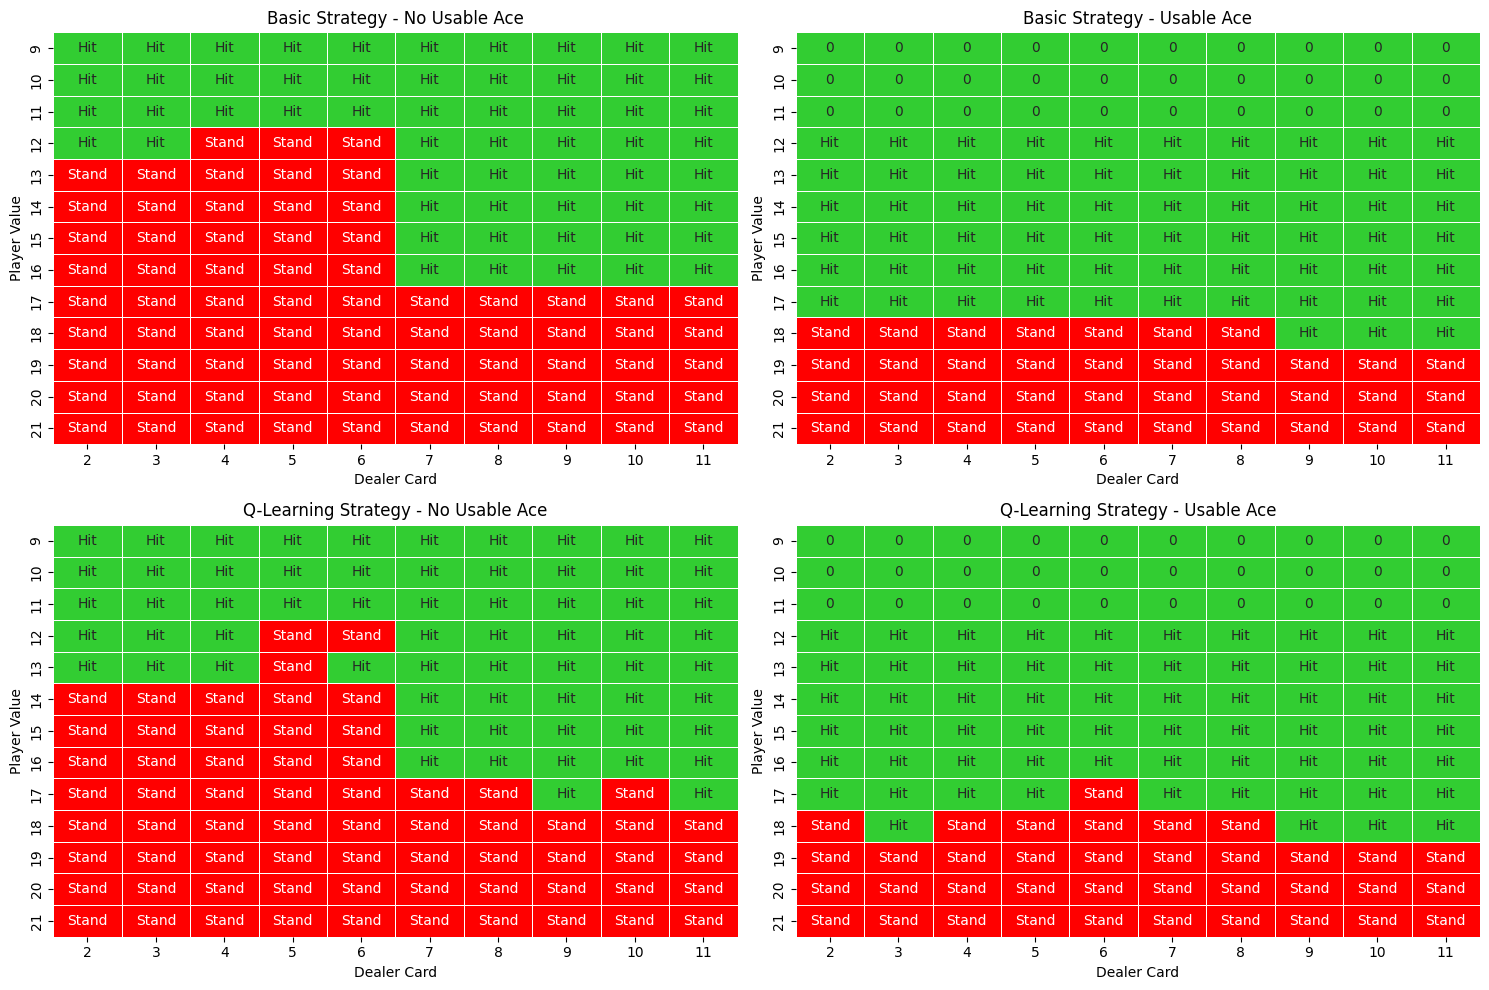

In [31]:
visualize_blackjack_policies("basic_strat.csv", "double_q_strat.csv")